# Graph-based RAG System Workshop

## Planning
1. Understanding Graph Rag
2. Retriever Architecture
3. What can be changed/how can it be improved?

## improve accuracy
1. modify and undertand how parameters can influence the retrieval:
    1. reduce or increase the similarity tresholds
    2. traverse the graph deeper
    3. improve similarty matching
    4. create a graph representation of the claim (check the code ;)
    5. generate a cypher query directly from the LLM (text2graph)
    6. create parameter for a ready made query `MATCH (:RISK_OBJECT {text: $value})
    7. ...
2. clone the repo and try to run evaluations.
3. improve the graph for example:
    1. remove sections that do not bring any information on coverage (reduce noise)
    2. change context window size, chunking methodology, etc.
    3. change the way embedings are constructured (do not forget to change the way the embedding is created on the query)

# What is Graph RAG

Graph RAG (Retrieval Augmented Generation) is an advanced approach to information retrieval and generation that combines the power of graph databases with Large Language Models (LLMs). Unlike traditional RAG systems that rely solely on vector similarity, Graph RAG leverages both semantic relationships and structural connections between pieces of information.

### Key Components:

1. **Vector Search**: Uses embeddings to find semantically similar content
   - Converts queries into vector representations
   - Finds similar nodes based on semantic similarity
   - Applies importance scores and type-specific adjustments

2. **Graph Structure**: Maintains relationships between information
   - Stores different types of entities (e.g., BENEFIT, EXCLUSION, LIMIT)
   - Captures relationships (e.g., APPLIES_TO, CONTAINS, EXCLUDES)
   - Enables traversal through connected information

3. **Context Enrichment**: Enhances retrieval with graph relationships
   - Extracts subgraphs around relevant nodes
   - Considers relationship types and hop depth
   - Provides richer context for LLM analysis

### Advantages:

- **Better Context**: Captures relationships between pieces of information
- **Structured Reasoning**: Follows explicit paths and relationships
- **Enhanced Accuracy**: Combines semantic and structural relevance
- **Explainable Results**: Clear path of reasoning through the graph

In this workshop, we'll implement a Graph RAG system for insurance policy analysis, demonstrating how to combine Memgraph (drop in replacement for Neo4j) graph database, OpenAI embeddings, and LLM-powered analysis for intelligent document processing.

# Graph Databases vs Relational Databases

### What is a Graph Database?

A graph database is a database that uses graph structures to store and represent data, with:
- **Nodes**: Representing entities (like people, products, or policies)
- **Edges**: Representing relationships between entities
- **Properties**: Attributes that can be attached to both nodes and edges

### Key Differences from Relational Databases

1. **Data Model**
   - **Relational**: Data is stored in tables with rows and columns
   - **Graph**: Data is stored as nodes and relationships, mirroring real-world connections

2. **Relationships**
   - **Relational**: Relationships are implied through foreign keys and joins
   - **Graph**: Relationships are first-class citizens, explicitly stored and traversed

3. **Query Performance**
   - **Relational**: Joins become expensive with increasing data complexity
   - **Graph**: Relationship traversal remains constant regardless of total database size

### Advantages of Graph Databases

1. **Natural Data Modeling**
   - Intuitive representation of connected data
   - Easier to model complex relationships
   - More flexible schema evolution

2. **Performance for Connected Data**
   - Faster traversal of relationships
   - No need for expensive JOIN operations
   - Constant-time traversal regardless of database size

3. **Query Capabilities**
   - Native support for pattern matching
   - Efficient path finding and graph algorithms
   - Better support for recursive queries

4. **Use Case Advantages**
   - Recommendation engines
   - Fraud detection
   - Social networks
   - Knowledge graphs
   - Supply chain management

### Example: Insurance Policy Analysis

In our case, graph databases are particularly useful because insurance policies have:
- Complex relationships between clauses
- Hierarchical structures (policies → sections → clauses)
- Multiple interconnected entities (coverages, exclusions, conditions)
- Need for path-based queries ("What exclusions apply to this coverage?")

# Retriever Architecture


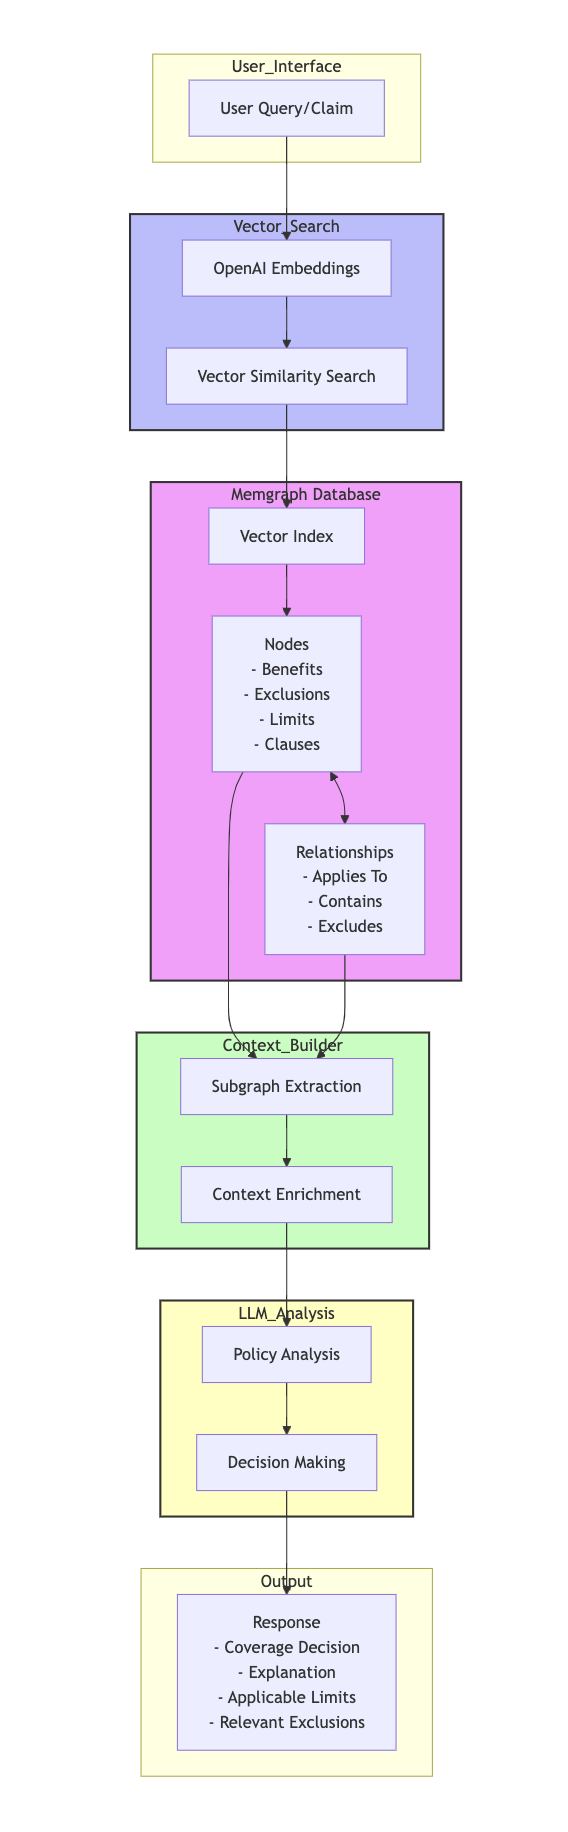

### Flow Explanation:

1. **Query Processing**:
   - User submits an insurance claim query
   - Query is converted to vector embeddings using OpenAI

2. **Retrieval**:
   - Vector similarity search finds relevant policy nodes
   - Graph database provides structural context
   - Subgraph extraction captures related information

3. **Analysis**:
   - Context builder combines vector and graph information
   - LLM analyzes claim against policy context
   - Generates structured response with coverage decision

4. **Response**:
   - Returns coverage decision
   - Provides explanation with policy references
   - Lists applicable limits and exclusions

# Ingestion Process

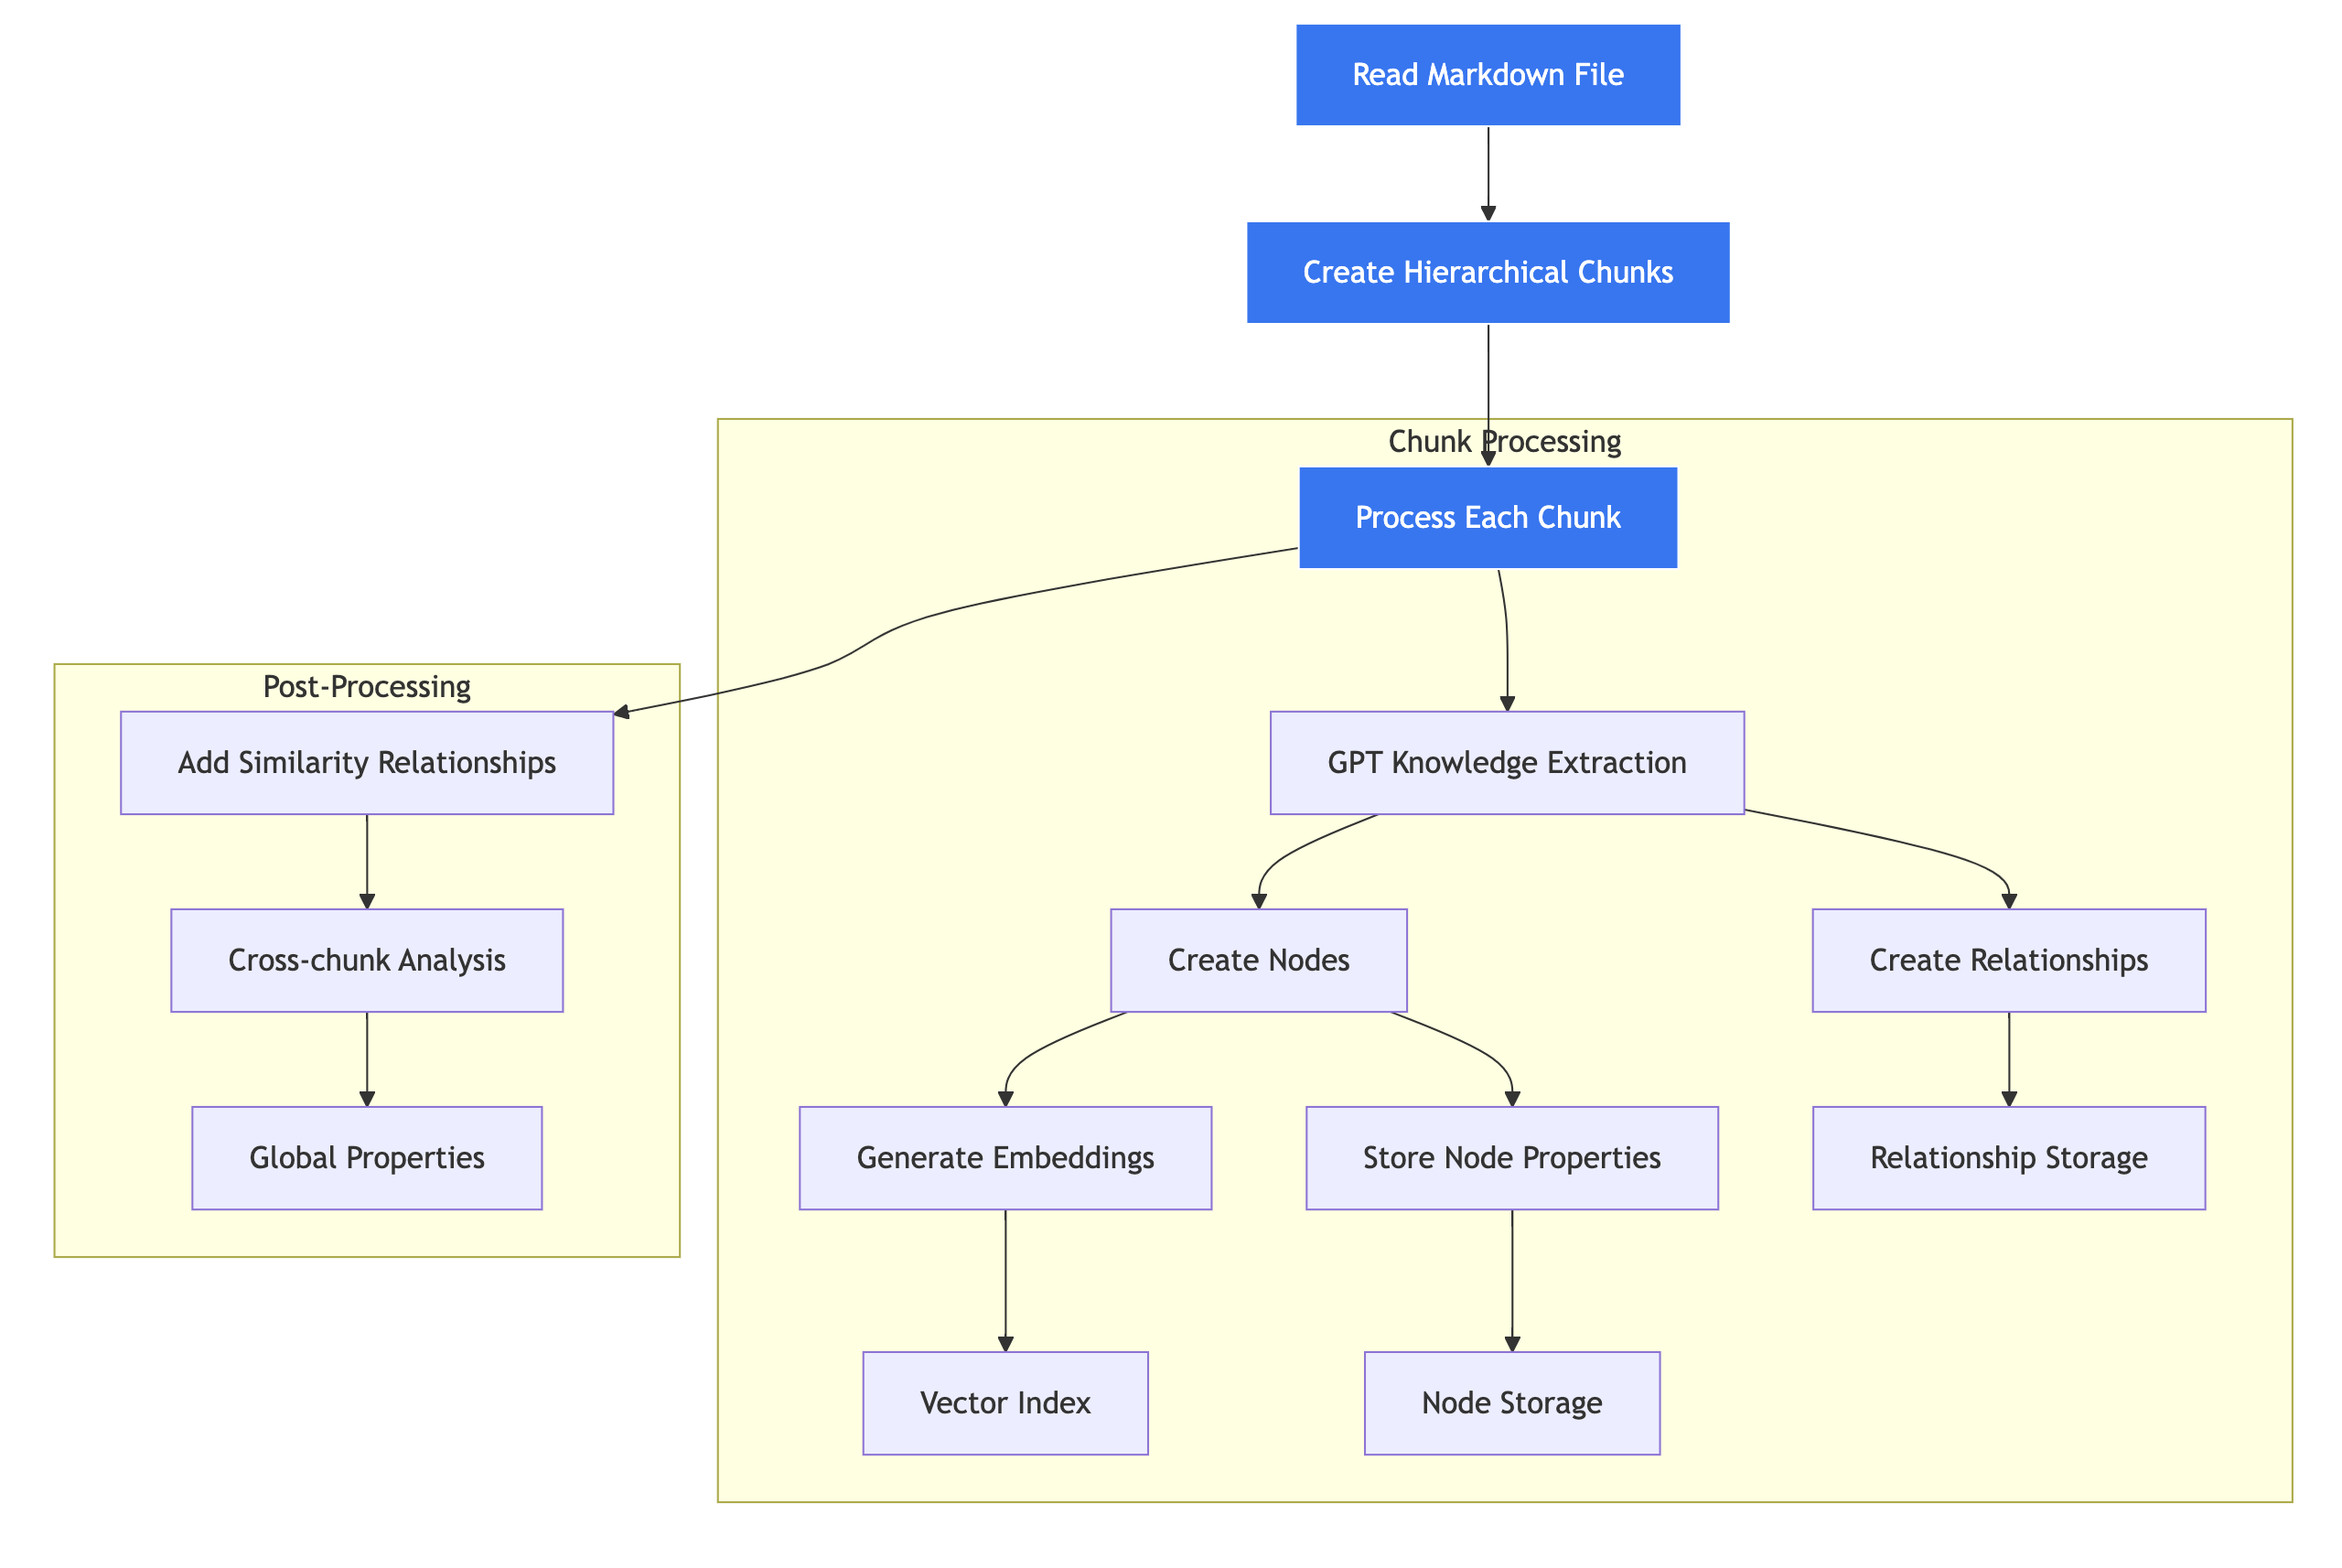

# Config

In [ ]:
# Install required packages
!pip install openai neo4j

In [ ]:
# Import required libraries
import logging
import sys
import json
from typing import List, Dict, Any
from openai import OpenAI
from neo4j import GraphDatabase

from google.colab import userdata

In [ ]:
# =====================================
# Configuration Section
# =====================================
# Replace these with your actual credentials
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
MEMGRAPH_HOST = "bolt+ssc://3.123.228.201:7687"
MEMGRAPH_USER = userdata.get('MEMGRAPH_USER') # amld2025.a3m83@simplelogin.com
MEMGRAPH_PASSWORD = userdata.get('MEMGRAPH_PASSWORD' ) # rURdDP&!8Kpr6!

amld2025.a3m83@simplelogin.com rURdDP&!8Kpr6!


# Parameter

In [ ]:
# Vector Search Settings
VECTOR_SIMILARITY_THRESHOLD = 0.40  # Minimum similarity score for vector search results
MIN_IMPORTANCE_SCORE = 0.0  # Minimum importance score for nodes to be considered
MAX_RESULTS = 7  # Maximum number of similar nodes to retrieve

# Graph Traversal Settings
MAX_HOP_DEPTH = 5  # Maximum number of hops when extracting subgraph relationships
IGNORE_RELATIONSHIP_TYPES = ["SEMANTICALLY_SIMILAR"]  # Relationship types to ignore during traversal

# Type-Specific Similarity Adjustments
SIMILARITY_ADJUSTMENTS = {
    "EXCLUSION": 0.8,  # Reduce importance of exclusions by 20%
    "LIMIT": 1.2,  # Boost importance of limits by 20%
}

# LLM Analysis Settings
SYSTEM_PROMPT_TEMPERATURE = 0.0  # Temperature for initial claim analysis
MAX_RETRIES = 3  # Maximum number of retries for LLM calls
RETRY_TEMPERATURE_INCREMENT = 0.1  # Temperature increment on each retry

# Cache Settings
ENABLE_CLAIM_GRAPH_CACHE = True  # Whether to cache extracted claim graphs
ENABLE_EMBEDDING_CACHE = True  # Whether to cache claim embeddings

# Logging Settings
LOG_SIMILAR_NODES = True  # Whether to log found similar nodes
LOG_SUBGRAPH_EXTRACTION = True  # Whether to log subgraph extraction details
DEBUG_FIRST_N_RESULTS = 3  # Number of top results to log in debug mode

VECTOR_INDEX_NAME = "vector_index"


# Entity and Relation Types
POSSIBLE_ENTITIES = [
    "BENEFIT",
    "CLAIM_PROCEDURE",
    "CLAUSE",
    "CONDITION",
    "COVERAGE",
    "DEDUCTIBLE",
    "DEFINITION",
    "ENDORSEMENT",
    "EVENT",
    "EXCESS",
    "EXCLUSION",
    "LIMIT",
    "ORGANIZATION",
    "PAYOUT",
    "PERIL",
    "PERSON",
    "POLICYHOLDER",
    "PREMIUM",
    "RISK_OBJECT",
    "SCHEDULE",
    "SECTION",
    "SERVICE",
    "SUBSECTION",
    "TERM",
]

POSSIBLE_RELATIONSHIPS = [
    "AMENDS",
    "APPLIES_TO",
    "CONTAINS",
    "COVERS",
    "DESCRIBES",
    "EXCLUDES",
    "FOLLOWS",
    "HAS_CERTIFICATE",
    "HAS_SCHEDULE",
    "IMPACTS",
    "LEADS_TO",
    "MENTIONS",
    "PAYABLE_FOR",
    "PRECEDES",
    "PROVIDES",
    "REFERENCES",
    "VALID_DURING",
]

# Utility Classes

In [ ]:
# =====================================
# Memgraph Client
# =====================================
class MemgraphClient:
    """A client for interacting with Memgraph database.

    This client provides comprehensive functionality for:
    - Managing graph database connections
    - Performing vector similarity search
    - Creating and querying graph structures
    - Managing nodes and relationships
    - Extracting subgraphs and context
    """
    def __init__(self, uri: str, auth: tuple, database: str = "memgraph"):
        self.driver = GraphDatabase.driver(uri, auth=auth)
        self.database = database
        self.driver.verify_connectivity()

    def close(self):
        """Close the driver connection."""
        self.driver.close()


    def find_similar_nodes(self, embedding: List[float], limit: int = MAX_RESULTS,
                          min_similarity: float = VECTOR_SIMILARITY_THRESHOLD,
                          min_importance: float = MIN_IMPORTANCE_SCORE) -> List[Dict[str, Any]]:
        """
        Hybrid search with metadata filtering and type-specific adjustments.
        """
        query = f"""
        CALL vector_search.search("{VECTOR_INDEX_NAME}", $limit, $embedding)
        YIELD node, similarity
        WITH node, similarity
        WHERE
            node.type IN $allowed_types
            AND similarity > $min_similarity
            AND coalesce(node.importance_score, 1.0) > $min_importance
        WITH
            node,
            similarity,
            CASE node.type
                WHEN 'EXCLUSION' THEN $exclusion_adjustment * similarity
                WHEN 'LIMIT' THEN $limit_adjustment * similarity
                ELSE similarity
            END as adjusted_score
        RETURN
            ID(node) as id,
            node.text as text,
            node.type as type,
            node.description as description,
            node.value as value,
            node.applies_to as applies_to,
            node.context as context,
            similarity,
            node.community as community,
            node.betweenness_centrality as centrality
        ORDER BY
            adjusted_score DESC
        LIMIT $limit
        """

        try:
            result = self.driver.execute_query(
                query,
                embedding=embedding,
                limit=limit,
                allowed_types=POSSIBLE_ENTITIES,
                min_similarity=min_similarity,
                min_importance=min_importance,
                exclusion_adjustment=SIMILARITY_ADJUSTMENTS["EXCLUSION"],
                limit_adjustment=SIMILARITY_ADJUSTMENTS["LIMIT"]
            )

            # Properly extract records from Neo4j result
            records = result.records
            print(f"Found {len(records)} potential nodes")
            if records:
                print(f"First 3 results: {records[:3]}")

            # Convert Neo4j records to dictionaries
            return [dict(record.items()) for record in records]

        except Exception as e:
            print(f"Vector search failed: {e}")
            return []

    def extract_subgraph_for_nodes(self, nodes: List[Dict], max_depth: int = MAX_HOP_DEPTH) -> Dict:
        """Extract a subgraph containing the given nodes and their relationships."""
        if not nodes:
            return {"graph_text": []}

        node_ids = [node["id"] for node in nodes]

        print(f"""Traversing the graph from :{node_ids}""")

        query = f"""
            UNWIND $node_ids AS node_id
            MATCH (n) WHERE id(n) = node_id
            MATCH path = (n)-[r*1..{max_depth}]-(m)
            WHERE id(m) <> id(n)
            AND NONE(rel IN r WHERE type(rel) IN {IGNORE_RELATIONSHIP_TYPES})

            WITH COLLECT(DISTINCT n) + COLLECT(DISTINCT m) AS all_nodes,
                COLLECT(DISTINCT path) AS all_paths

            UNWIND all_nodes AS node
            WITH node, all_paths
            WHERE
                COALESCE(node.description, "") <> "" OR
                COALESCE(node.text, "") <> "" OR
                COALESCE(TOSTRING(node.value), "N/A") <> "N/A"

            WITH
                COLLECT(DISTINCT
                    node.type +
                    (CASE WHEN COALESCE(node.description, "") <> "" THEN ": '" + node.description + "'" ELSE "" END) +
                    (CASE WHEN COALESCE(node.text, "") <> "" THEN " - '" + node.text + "'" ELSE "" END) +
                    (CASE WHEN COALESCE(TOSTRING(node.value), "N/A") <> "N/A" THEN " - Value: " + TOSTRING(node.value) ELSE "" END)
                ) AS node_descriptions,
                all_paths

            UNWIND all_paths AS path
            UNWIND relationships(path) AS rel
            WITH node_descriptions, path,
                startNode(rel) AS start_node,
                endNode(rel) AS end_node,
                type(rel) AS rel_type

            WITH node_descriptions, end_node, rel_type, start_node
            WHERE
                COALESCE(start_node.description, "") <> "" OR
                COALESCE(start_node.text, "") <> "" OR
                COALESCE(TOSTRING(start_node.value), "N/A") <> "N/A"

            WITH node_descriptions, end_node, rel_type,
                COLLECT(DISTINCT
                    (CASE WHEN COALESCE(start_node.description, "") <> "" THEN "'" + start_node.description + "'" ELSE "" END) +
                    (CASE WHEN COALESCE(start_node.text, "") <> "" THEN " - '" + start_node.text + "'" ELSE "" END) +
                    (CASE WHEN COALESCE(TOSTRING(start_node.value), "N/A") <> "N/A" THEN " - Value: " + TOSTRING(start_node.value) ELSE "" END)
                ) AS start_node_texts

            WITH node_descriptions, end_node, rel_type, start_node_texts,
                CASE
                    WHEN SIZE(start_node_texts) > 1 THEN
                        "(" + REDUCE(merged = "", text IN start_node_texts |
                            CASE WHEN merged = "" THEN text ELSE merged + " OR " + text END) + ")"
                    ELSE
                        HEAD(start_node_texts)
                END AS merged_start_nodes

            WITH node_descriptions,
                merged_start_nodes + " -[" + rel_type + "]-> " +
                "(" + end_node.type +
                (CASE WHEN COALESCE(end_node.description, "") <> "" THEN ": '" + end_node.description + "'" ELSE "" END) +
                (CASE WHEN COALESCE(end_node.text, "") <> "" THEN " - '" + end_node.text + "'" ELSE "" END) +
                (CASE WHEN COALESCE(TOSTRING(end_node.value), "N/A") <> "N/A" THEN " - Value: " + TOSTRING(end_node.value) ELSE "" END) +
                ")"
                AS grouped_path

            WITH node_descriptions, COLLECT(DISTINCT grouped_path) AS optimized_paths
            RETURN optimized_paths AS graph_text
        """

        try:
            result = self.driver.execute_query(query, {"node_ids": node_ids})
            records = result.records

            # Simply return the graph_text from the first record
            if records and hasattr(records[0], 'get'):
                return {"graph_text": records[0].get('graph_text', [])}

            return {"graph_text": []}

        except Exception as e:
            print(f"Error extracting subgraph: {e}")
            return {"graph_text": []}


    def get_connected_nodes(self, node_ids: List[int]) -> List[str]:
        """Updated to match project's graph traversal implementation"""
        query = """
        MATCH (start)-[r*1..5]-(end)
        WHERE ID(start) IN $node_ids
            AND NONE(rel IN r WHERE type(rel) IN $ignore_rels)
        RETURN nodes(r) as path_nodes, relationships(r) as path_rels
        """
        try:
            result = self.execute_query(query, {
                "node_ids": node_ids,
                "ignore_rels": IGNORE_RELATIONSHIP_TYPES
            })
            return {"graph_text": self._process_paths(result)}
        except Exception as e:
            print(f"Graph traversal failed: {str(e)}")
            return {"graph_text": []}


In [ ]:
# =====================================
# OpenAI Service
# =====================================
class OpenAIService:
    def __init__(self, api_key: str):
        self.client = OpenAI(api_key=api_key)
        self.embedding_model = "text-embedding-3-small"
        self.chat_model = "gpt-4o"

    def get_embedding(self, text: str) -> List[float]:
        """Get embedding for a text using OpenAI's API."""
        try:
            response = self.client.embeddings.create(
                model=self.embedding_model,
                input=text
            )
            return response.data[0].embedding
        except Exception as e:
            print(f"Error getting embedding: {str(e)}")
            raise

    def chat_completion(self, messages: List[Dict[str, str]]) -> str:
        """Get chat completion from OpenAI's API with JSON enforcement."""
        try:
            response = self.client.chat.completions.create(
                model=self.chat_model,
                messages=messages,
                temperature=0,
                response_format={"type": "json_object"}  # Enforce JSON output
            )
            content = response.choices[0].message.content

            # Validate JSON structure
            json.loads(content)
            return content

        except json.JSONDecodeError as e:
            print(f"Invalid JSON response: {content}")
            raise ValueError("LLM returned invalid JSON") from e
        except Exception as e:
            print(f"Error in chat completion: {str(e)}")
            raise

# Retriever

In [ ]:
# =====================================
# Policy Retriever
# =====================================
class PolicyRetriever:
    def __init__(self, memgraph_client: MemgraphClient, openai_service: OpenAIService):
        self.mg_client = memgraph_client
        self.openai = openai_service
        self.system_prompt = """**Insurance Policy Analysis Protocol**

        1. **Claim-Policy Mapping**
        - Match each claim element to EXACT policy clauses
        - Require verbatim text matches for conditions

        2. **Exclusion Check**
        - Check ALL exclusions in context
        - Apply exclusion if ANY match

        3. **Limit Application**
        - Apply MOST SPECIFIC limit first
        - Sum applicable limits

        4. **Coverage Requirements**
        - Verify ALL required conditions met
        - Reject if ANY missing

        5. **Decision Framework**
        IF ANY exclusion applies → Deny
        ELIF any condition unmet → Deny
        ELIF claim > limit → Partial coverage
        ELSE → Full coverage

        **Output Requirements**
        - Cite EXACT policy text for decisions
        - List MISSING requirements if denied
        - Calculate SPECIFIC amounts if limited"""

    def _build_prompt(self, claim_text: str, context: str) -> str:
        """Build the prompt with explicit format requirements"""
        format_example = json.dumps({
            "coverage": True,
            "explanation": "Detailed explanation...",
            "limits": [{
                "type": "Limit Type",
                "amount": 5000,
                "unit": "USD",
                "applies_to": "Damage Type",
                "source": "CLAUSE 2.1"
            }],
            "exclusions": [{
                "text": "Exclusion text",
                "applies": True,
                "reason": "Why it applies",
                "source": "EXCLUSION 3"
            }],
            "description": "Brief claim summary"
        }, indent=2)

        return f"""You are an insurance policy analyzer. Analyze this claim:

        CLAIM:
        {claim_text}

        POLICY CONTEXT:
        {context}

        Provide response in EXACTLY this JSON format:
        {format_example}

        Notes:
        - Verify ALL required conditions are met
        - Check for ANY applicable exclusions
        - Calculate amounts using policy schedules"""

    def build_context_text(self, similar_nodes: List[Dict], connected_data: Dict) -> str:
        """Policy context with structured node properties and relationships"""
        if not similar_nodes:
            return "No relevant policy information found"

        core_elements = [
            f"({node['type']}) {node.get('text', '')}"
            + (f"\n- Value: {node['value']}" if node.get('value') else "")
            + (f"\n- Description: {node['description']}" if node.get('description') else "")
            for node in similar_nodes
        ]

        return "\n".join([
            "## CORE POLICY ELEMENTS:",
            "\n".join(core_elements),
            "\n## POLICY RELATIONSHIPS:",
            "\n".join(connected_data.get("graph_text", []))
        ])

    def reason_about_claim(self, query: str, top_k: int = MAX_RESULTS) -> Dict[str, Any]:
        """Claim analysis"""
        # Get embedding
        query_embedding = self.openai.get_embedding(query)

        # Find similar nodes
        similar_nodes = self.mg_client.find_similar_nodes(query_embedding, top_k)
        if not similar_nodes:
            return {"error": "No relevant policy information found"}

        # Extract subgraph
        subgraph = self.mg_client.extract_subgraph_for_nodes(similar_nodes)

        # Build context
        context = self.build_context_text(similar_nodes, subgraph)

        print("Context:")
        print(context)

        # Generate analysis
        messages = [
            {"role": "system", "content": self.system_prompt},
            {"role": "user", "content": self._build_prompt(query, context)}
        ]

        try:
            response = self.openai.chat_completion(messages)
            return json.loads(response)
        except Exception as e:
            print(f"Analysis failed: {str(e)}")
            return {"error": "Failed to analyze claim"}

In [ ]:
# =====================================
# Main Execution
# =====================================
def main():
    # Initialize services
    memgraph_client = MemgraphClient(
        uri=MEMGRAPH_HOST,
        auth=(MEMGRAPH_USER, MEMGRAPH_PASSWORD)
    )
    openai_service = OpenAIService(api_key=OPENAI_API_KEY)

    # Initialize retriever
    retriever = PolicyRetriever(memgraph_client, openai_service)

    # Example query
    example_query = """
    I was driving with 7 passengers from Sheffield to London.
    The car broke down on the way and we had to take a hotel room for the night
    while the car was being repaired. The invoice is 400 pounds.
    """

    try:
        # Process query
        result = retriever.reason_about_claim(example_query, top_k=5)
        print("\nResult:")
        print(json.dumps(result, indent=4))

    finally:
        # Cleanup
        memgraph_client.close()

if __name__ == "__main__":
    main()

Found 5 potential nodes
First 3 results: [<Record id=170 text='Hotel expenses and alternative transport' type='BENEFIT' description='Payment for hotel expenses and alternative transport if car is not roadworthy' value='up to £250' applies_to='' context='For damage to the engine, the excess shown in your schedule under accidental damage will apply.\n\n## 7 Child car seats\n\nIf your car is fitted with any child car seats, we will pay up to £300 for their replacement with the same or similar model following an accident covered by this policy. We will pay for the replacement whether or not visible damage has been caused to the child car seat.' similarity=0.5008593201637268 community=None centrality=None>, <Record id=171 text='Overnight accommodation' type='BENEFIT' description='Cover for overnight accommodation including meals and drinks' value='included in hotel expenses' applies_to='' context='For damage to the engine, the excess shown in your schedule under accidental damage will apply